# Victim Analysis Notebook (SOC/IDS)

This notebook analyzes the `network_logs.csv` file acting as a **Security Operations Center (SOC)** dashboard.
It performs:
1.  **Intrusion Detection** (Signature & Anomaly based)
2.  **Traffic Analysis** (Volume & Distribution)
3.  **Forensics** (Timeline & Attacker Profiling)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set_style("darkgrid")

# Load the logs
try:
    df = pd.read_csv('network_logs.csv')
    # Convert timestamp to datetime objects
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print("Logs loaded successfully.")
    print(f"Total entries: {len(df)}")
    print(f"Time Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
except FileNotFoundError:
    print("Error: network_logs.csv not found. Please run the attacker simulation first.")
except Exception as e:
    print(f"Error loading logs: {e}")

Logs loaded successfully.
Total entries: 41
Time Range: 2026-02-02 20:40:41 to 2026-02-02 21:20:15


## 1. Automated Intrusion Detection System (IDS)
Runs detection logic on the dataset to flag malicious events.

In [8]:
def detect_threats(df):
    threats = []
    
    # 1. DoS Detection: > 100 requests from single IP
    request_counts = df[df['action'] == 'HTTP_REQUEST']['source_ip'].value_counts()
    for ip, count in request_counts.items():
        if count > 100:
            threats.append({'IP': ip, 'Type': 'DoS Attack', 'Details': f'{count} requests (High Volume)'})

    # 2. Network Recon (Scanner Fingerprint)
    recon_df = df[df['details'].str.contains('Scanner|Nmap', case=False, na=False)]
    for ip in recon_df['source_ip'].unique():
        threats.append({'IP': ip, 'Type': 'Network Recon', 'Details': 'Scanner Fingerprint Detected'})

    # 3. Brute Force (> 5 failed logins)
    login_df = df[(df['action'] == 'LOGIN_ATTEMPT') & (df['details'].str.contains('Failed', na=False))]
    for ip, count in login_df['source_ip'].value_counts().items():
        if count > 5:
            threats.append({'IP': ip, 'Type': 'Brute Force', 'Details': f'{count} failed attempts'})

    # 4. SQL Injection (Pattern Match)
    sqli_df = df[(df['action'] == 'LOGIN_ATTEMPT') & 
                 (df['details'].str.contains("' OR|UNION SELECT|1=1", case=False, na=False))]
    for ip in sqli_df['source_ip'].unique():
         threats.append({'IP': ip, 'Type': 'SQL Injection', 'Details': 'SQLi payload detected'})

    # 5. XSS (Pattern Match)
    xss_df = df[(df['action'] == 'SEARCH_QUERY') & 
                (df['details'].str.contains(r"<script>|alert\(", case=False, na=False))]
    for ip in xss_df['source_ip'].unique():
         threats.append({'IP': ip, 'Type': 'XSS Attack', 'Details': 'XSS payload detected'})

    # 6. Command Injection (Pattern Match)
    ci_df = df[(df['action'] == 'SEARCH_QUERY') & 
               (df['details'].str.contains(";|/etc/passwd", case=False, na=False))]
    for ip in ci_df['source_ip'].unique():
         threats.append({'IP': ip, 'Type': 'Command Injection', 'Details': 'RCE payload detected'})
            
    return pd.DataFrame(threats)

if 'df' in locals():
    threats_df = detect_threats(df)
    print("\n--- THREAT REPORT ---")
    if not threats_df.empty:
        print(threats_df)
    else:
        print("No threats detected.")


--- THREAT REPORT ---
              IP               Type                       Details
0      127.0.0.1      Network Recon  Scanner Fingerprint Detected
1  192.168.1.110        Brute Force            10 failed attempts
2  192.168.1.110      SQL Injection         SQLi payload detected
3  192.168.1.110         XSS Attack          XSS payload detected
4  192.168.1.110  Command Injection          RCE payload detected


## 2. Threat Visualizations

C:\Users\John\AppData\Local\Temp\ipykernel_17448\2017060572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Type', data=threats_df, palette='Reds_r', order=threats_df['Type'].value_counts().index)


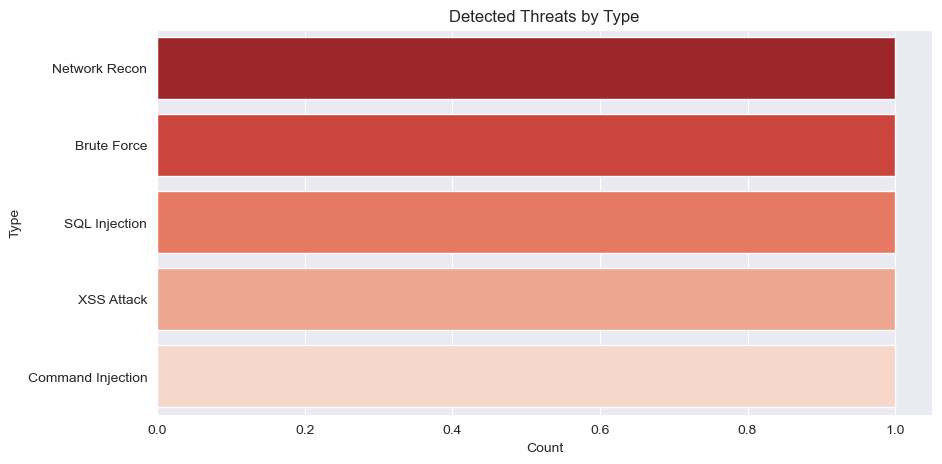

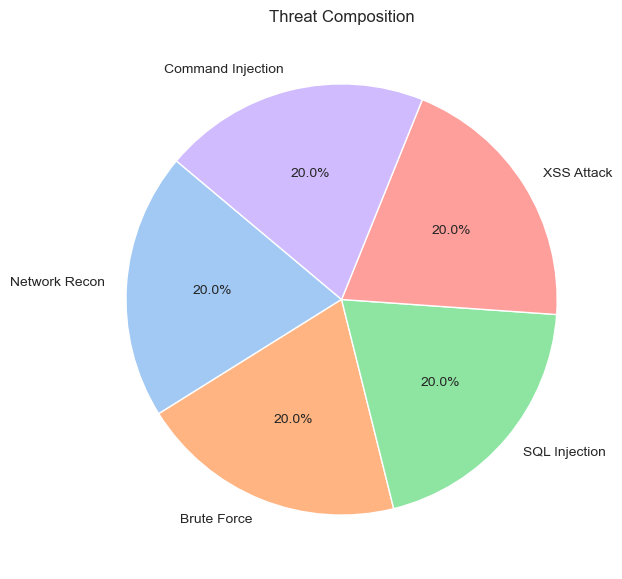

In [9]:
if 'threats_df' in locals() and not threats_df.empty:
    # 1. Threat Type Distribution (Bar Chart)
    plt.figure(figsize=(10, 5))
    sns.countplot(y='Type', data=threats_df, palette='Reds_r', order=threats_df['Type'].value_counts().index)
    plt.title('Detected Threats by Type')
    plt.xlabel('Count')
    plt.show()
    
    # 2. Threat Distribution (Pie Chart)
    plt.figure(figsize=(7, 7))
    type_counts = threats_df['Type'].value_counts()
    plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Threat Composition')
    plt.show()

## 3. Temporal Analysis (Timeline)
Visualizing traffic volume to spot **DoS Attacks** and **Scan Windows**.

C:\Users\John\AppData\Local\Temp\ipykernel_17448\3478378641.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_resampled = df.set_index('timestamp').resample('1S').size()


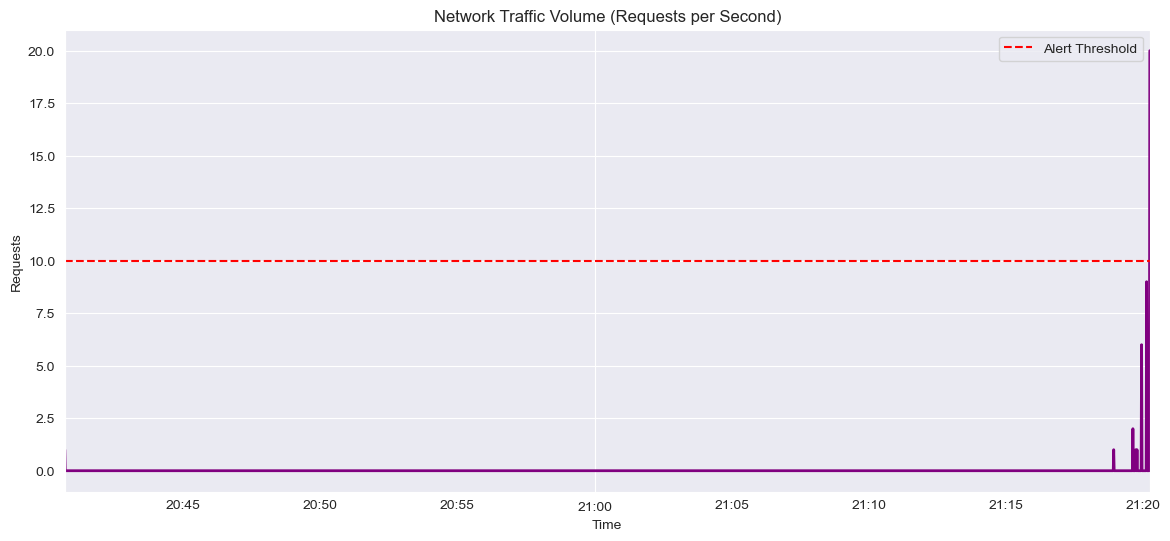

In [10]:
if 'df' in locals():
    # Resample data by Second to see traffic spikes
    # We create a 'count' column for aggregation
    df_resampled = df.set_index('timestamp').resample('1S').size()
    
    plt.figure(figsize=(14, 6))
    df_resampled.plot(color='purple', lw=2)
    plt.title('Network Traffic Volume (Requests per Second)')
    plt.ylabel('Requests')
    plt.xlabel('Time')
    
    # Highlight Threshold
    plt.axhline(y=10, color='red', linestyle='--', label='Alert Threshold')
    plt.legend()
    plt.show()

## 4. Attacker Profiling
Who are the most aggressive IPs?

C:\Users\John\AppData\Local\Temp\ipykernel_17448\2766245666.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_attackers.values, y=top_attackers.index, palette='magma')


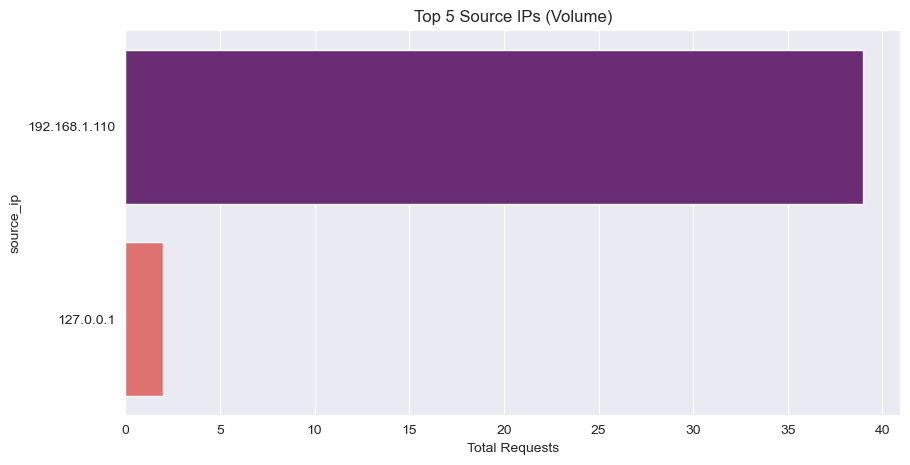

In [11]:
if 'df' in locals():
    top_attackers = df['source_ip'].value_counts().head(5)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_attackers.values, y=top_attackers.index, palette='magma')
    plt.title('Top 5 Source IPs (Volume)')
    plt.xlabel('Total Requests')
    plt.show()

## 5. Detailed Forensic Log
Filter the log to show only the malicious payloads for review.

In [12]:
if 'df' in locals():
    # Filter for interesting keywords
    malicious_keywords = ["' OR", "UNION SELECT", "<script>", "alert(", ";", "/etc/passwd", "Scanner", "Failed"]
    pattern = '|'.join([java.util.regex.Pattern.quote(k) if False else k for k in malicious_keywords]) 
    # Simplified regex for pandas
    pattern = r"' OR|UNION SELECT|<script>|alert\(|;|/etc/passwd|Scanner|Failed"
    
    forensic_view = df[df['details'].str.contains(pattern, case=False, na=False)]
    
    print(f"Found {len(forensic_view)} suspicious log entries. Showing last 10:")
    display(forensic_view[['timestamp', 'source_ip', 'action', 'details']].tail(10))

Found 14 suspicious log entries. Showing last 10:


,timestamp,source_ip,action,details
5,2026-02-02 21:19:47,192.168.1.110,SEARCH_QUERY,Query: ; cat /etc/passwd
12,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: admin
13,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: admin
14,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: admin
15,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: jdoe
16,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: jdoe
17,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: jdoe
18,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: root
19,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: root
20,2026-02-02 21:20:08,192.168.1.110,LOGIN_ATTEMPT,Failed login: root
